In [1]:
%matplotlib inline
import time
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import pandas as pd
plt.rcParams.update({'font.size': 14})
    
def velocityoftheparticle(distancelaser):      #Calculate the thermophoretic velocity due to the laser offset
    if distancelaser <= 2.5e-6:
        foundit = 0; k = 0
        while foundit == 0:
            if velparticle[k,0] > distancelaser: foundit = 1
            else: k += 1
        m = (velparticle[k,1]-velparticle[k-1,1])/(velparticle[k,0]-velparticle[k-1,0])
        n = velparticle[k,1] - m * velparticle[k,0]
        return m*distancelaser+n
    else: return 0

In [2]:
np.random.seed(4) 

stepsexp  = 10000                               #number of camera pictures
maxvelocity = 6e-6#5.25e-6                    #max velocity for the Velocity vs laser offset curve
                                                #Fig 1c; https://www.nature.com/articles/s41467-018-06445-1.pdf
diameter = 2.19e-6                              #diameter of the particle
dt = 0.03                                       #iteration time of the camera [s]
D_0 = 7.4e-14#D_0 = 3.85e-14                    #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
kB = 1.38064852e-23                             #Boltzmanns constant [J/K]
T = 273.15 + 20                                 #Room temperature [K]
eta = 2.414e-5*10**(247.8/(T-140))              #Viscosity [Pa*s]
substep = 10                                    #dt/substep - time for diffusion step
pxtomum = 0.0533e-6 #0.027e-6                   #px to µm conversion
offset = 14                                     #offset of the laser [px]
videosize = 1000                                #size of the video [px]
binning = 2
dtprogram = 13.6e-3                             #time of the program (tracking + calculation) [s]
dtsendtoadwin = 1e-3                            #time to send signal from PC to Adwin [s]
dttransferfromcamtocom = 1e-3                   #time to send from cam to PC (unknown) [s]
dtframetransfer = videosize/binning * 1.9176e-6         #time for frametransfer [s]
dtreadout = (1032/(27e6) + 1.9176e-6)*videosize/binning #time to readout the cam [s]
diffusion = True                                #Switching diffusion on and off
frametransfer = False
flashlight = True
flashtime = 0.01

In [3]:
dtreadout

0.020069911111111113

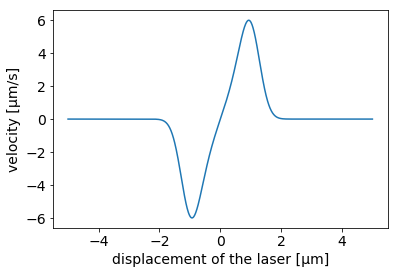

In [28]:
addtimelaser = dtreadout + dttransferfromcamtocom
if frametransfer == True: addtimelaser += dtframetransfer
length = substep * stepsexp
subdt = dt/substep                               #dt for diffusion
flashframe = max(int(flashtime/subdt),1)
shortlengthstart = int(length/substep)-1              #number of recorded camera pictures
prefactor = np.sqrt(2*D_0*subdt)                 #value for calculation of the random steps
radius = diameter/2
delaytime = dt/2+dtframetransfer+dtreadout+dtprogram+dtsendtoadwin*2 #Total delay time
                                                 
timewave = np.linspace(0,subdt*length,length,endpoint=False)  #Timewave for sub cam resolution
shorttimewave = np.linspace(0,dt*stepsexp,stepsexp,endpoint=False)  #Timewave for sub cam resolution
particles = np.zeros((length,5))                 #particle       0 - x; 1 - y; 2 - time; 3 - distance to laser
particles[:,3:5] = np.nan                        #               4 - velocity from laser 
particles[0,0] = 0
particles[0,1] = 0
laser = np.zeros((shortlengthstart+1,2))              #laserposition  0 - x; 1 - y;
particlescamera = np.zeros((shortlengthstart+1,11))   #cam detection  0 - x; 1 - y; 2 - time of the average particle position
                                                 #               3 - time at which the the laser is placed 
                                                 #               4 - xstep; 5 - ystep; 6 - step length
                                                 #               7/8 - Actual position of the particle at the timepoint of the laser positioning
                                                 #               9/10 x/y after substraction of the correction angle for drift
noisesteps = np.zeros((length,2))                #random steps
for i in range(2): noisesteps[:,i] = prefactor*np.random.normal(0,1,length)
deltas = np.zeros(2)

vel = np.loadtxt('DataVvsOffset.txt')
velparticle = np.zeros((len(vel),2))                #Load the velocity of the particle of depending on the distance to the laser
velparticle[:,0] = vel[:,0]*1e-6
velparticle[:,1] = -vel[:,1]
velparticle[:,1] *= maxvelocity/max(velparticle[:,1])

plt.plot(velparticle[:,0]*1e6,velparticle[:,1]*1e6)
plt.xlabel('displacement of the laser [µm]')
plt.ylabel('velocity [µm/s]')
plt.show()

In [29]:
timevalue = (substep) * subdt/2                                  #time difference between average particle position and end of picture recording
timevalue2 = addtimelaser + dtprogram + dtsendtoadwin                #time difference between end of picture recording and laser positioning
start_time = time.time()    
cameraframe = 0; laserframe = 0; readframe = 1
for i in range(1,length):                                                                                                            
    particles[i,2] = subdt*i                                         #Set Time
    particles[i,:2] = particles[i-1,:2]                              #Position equals position before
    if diffusion == True:
        for j in range(2): particles[i,j] += noisesteps[i,j]         #add diffusion
    if i % substep == 0 and i != 0:                                  #Particle position on the camera image every N frames
        cameraframe += 1
        if flashlight == False: 
            for j in range(2): particlescamera[cameraframe,j] = np.mean(particles[i-substep:i,j])
            particlescamera[cameraframe,2] = particles[i,2] - timevalue  #Time of the average particle position
        else: 
            for j in range(2): particlescamera[cameraframe,j] = np.mean(particles[i-substep:i-substep+flashframe,j])
            #print('start = ',i-substep,' - end = ',i-substep+flashframe)
            particlescamera[cameraframe,2] = particles[i,2] - (dt-flashtime/2)  #Time of the average particle position
        particlescamera[cameraframe,3] = particles[i,2] + timevalue2 #Time laser is placed
    if particles[i,2] >= particlescamera[readframe,3] and cameraframe > laserframe:
        if laserframe == 0: deletesteps = cameraframe
        laserframe += 1                                              #Set laser at right timepoint
        particlescamera[cameraframe,7] = particles[i,0]              #Actual position of the particle at the timepoint of the laser positioning
        particlescamera[cameraframe,8] = particles[i,1]
        laser[laserframe,0] = particlescamera[readframe,0]-offset*pxtomum#*np.cos(particlescamera[cameraframe,5]*np.pi/180)       
        laser[laserframe,1] = particlescamera[readframe,1]#offset*pxtomum*np.sin(particlescamera[cameraframe,5]*np.pi/180)
        readframe += 1                                     #Set laser position
    if laserframe > 0:
        for j in range(2): deltas[j] = particles[i,j]-laser[laserframe,j]
        particles[i,3] = np.sqrt(pow(deltas[0],2)+pow(deltas[1],2))  #Distance particle - laser
        particles[i,4] = velocityoftheparticle(particles[i,3])       #Resulting thermophoretic velocity
        for j in range(2): particles[i,j] += particles[i,4]/particles[i,3]*deltas[j]*subdt 
print("--- %s seconds ---" % round((time.time() - start_time),2))    #Add thermophotetic velocity
shortlength = shortlengthstart - deletesteps
particlescamera2 = particlescamera
particlescamera = np.zeros((shortlength,11))
particlescamera = particlescamera2[:shortlength,:]
laser2 = laser
laser = np.zeros((shortlength,2))
laser = laser2[:shortlength,:]

--- 17.9 seconds ---


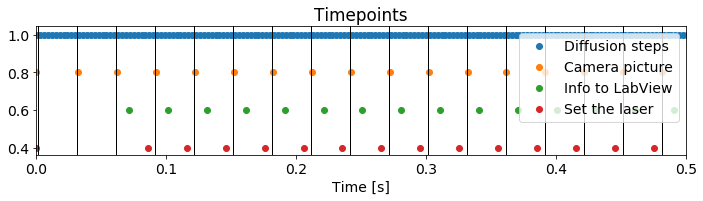

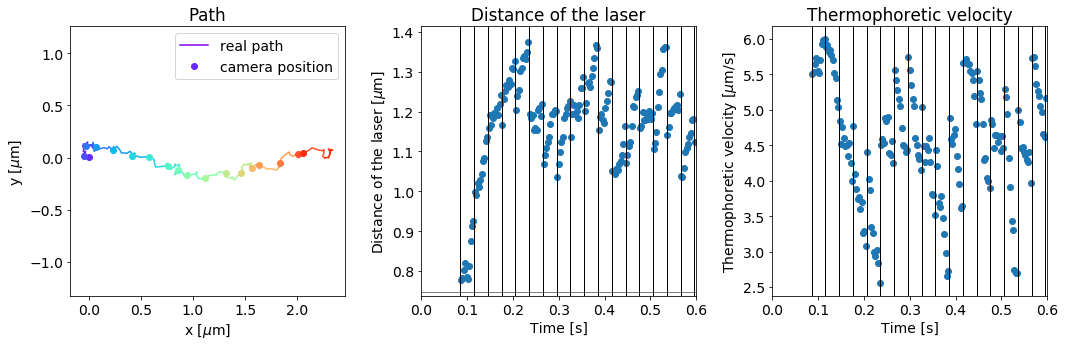

In [5]:
plotmaxpoints = 200
pointslong = min(plotmaxpoints,length)
pointsshort = int(pointslong/substep)
timelong = np.linspace(0,subdt*pointslong,pointslong,endpoint=False)
timeshort = np.linspace(0,dt*shortlength,shortlength,endpoint=False)
ones = np.ones(pointslong)
ones2 = np.ones(pointsshort)
ones3 = np.ones(pointsshort)

fig=plt.figure(1, figsize = (10,3) )   #Plot Visualisation of the time points
plt.scatter(particles[:pointslong,2],ones,label='Diffusion steps')
plt.scatter(particlescamera[:pointsshort,2],0.8*ones2,label='Camera picture')
plt.scatter(particlescamera[:pointsshort,3]- dtprogram - dtsendtoadwin,0.6*ones2,label='Info to LabView')
plt.scatter(particlescamera[:pointsshort,3],0.4*ones3,label='Set the laser')
for i in range(pointsshort): plt.axvline(x=dt*i-subdt/2+subdt,linewidth=1, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.xlim([0,0.5])
plt.title('Timepoints')
plt.tight_layout() 
plt.legend(loc='upper right')
#plt.savefig('Timepoints'+str(name)+'.pdf', format='pdf')
plt.show()        
  
spanx = max(particles[:pointslong,0])-min(particles[:pointslong,0])
spany = max(particles[:pointslong,1])-min(particles[:pointslong,1])
maxspan = max(spanx,spany)
if maxspan == spanx:
    xmin = min(particles[:pointslong,0])
    xmax = max(particles[:pointslong,0])
    ymin = np.mean(particles[:pointslong,1])-spanx/2
    ymax = np.mean(particles[:pointslong,1])+spanx/2
else:
    xmin = np.mean(particles[:pointslong,0])-spany/2
    xmax = np.mean(particles[:pointslong,0])+spany/2
    ymin = min(particles[:pointslong,1])
    ymax = max(particles[:pointslong,1])

fig=plt.figure(1, figsize = (15,5) )   #Plot Path, Laser distance and Velocity
ax =plt.subplot(1, 3, 1)
colorwave = cm.rainbow(np.linspace(0, 1, pointsshort))
for i in range(pointsshort-1):
    if i == 0: plt.plot(particles[i*substep:i*substep+substep+1,0]*1e6,particles[i*substep:i*substep+substep+1,1]*1e6, color=colorwave[i],label ='real path')
    else: plt.plot(particles[i*substep:i*substep+substep+1,0]*1e6,particles[i*substep:i*substep+substep+1,1]*1e6, color=colorwave[i])
    if i>0: 
        if i == 1: plt.plot(particlescamera[i,0]*1e6,particlescamera[i,1]*1e6,'o', color=colorwave[i],label='camera position')
        else: plt.plot(particlescamera[i,0]*1e6,particlescamera[i,1]*1e6,'o', color=colorwave[i])
plt.xlabel('x [$\mu$m]')
plt.ylabel('y [$\mu$m]')
plt.xlim([xmin*1e6,xmax*1e6])
plt.ylim([ymin*1e6,ymax*1e6])
ax.axis('equal')
ax = plt.gca()
plt.title('Path')
plt.legend()

plotlength = 200
ax =plt.subplot(1, 3, 2)
plt.scatter(timelong[:plotlength],particles[:plotlength,3]*1e6)
for i in range(1,int(plotlength/substep)): plt.axvline(x=particlescamera[i,3],linewidth=1, color = 'k',linestyle='-')
plt.axhline(y=offset*pxtomum*1e6,linewidth=0.5, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Distance of the laser [$\mu$m]')
plt.xlim([0,subdt*plotlength])
plt.title('Distance of the laser')

ax =plt.subplot(1, 3, 3)
plt.scatter(timelong[:plotlength],particles[:plotlength,4]*1e6)
for i in range(1,int(plotlength/substep)): plt.axvline(x=particlescamera[i,3],linewidth=1, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Thermophoretic velocity [$\mu$m/s]')
plt.xlim([0,subdt*plotlength])
plt.title('Thermophoretic velocity')
plt.tight_layout() 
plt.savefig('Path.pdf', format='pdf')
plt.show()

plotlength = min(shortlength,1000)
x = particlescamera[1:plotlength,0]*1e6
y = particlescamera[1:plotlength,1]*1e6
velocitywithdiffusion2 = np.zeros(plotlength-1)
velocitywithdiffusion2[0] = np.nan
for i in range(2,plotlength-1): velocitywithdiffusion2[i] = np.sqrt(pow(particlescamera[i,0]-particlescamera[i-1,0],2)+pow(particlescamera[i,1]-particlescamera[i-1,1],2))*1e6/dt 
v = velocitywithdiffusion2

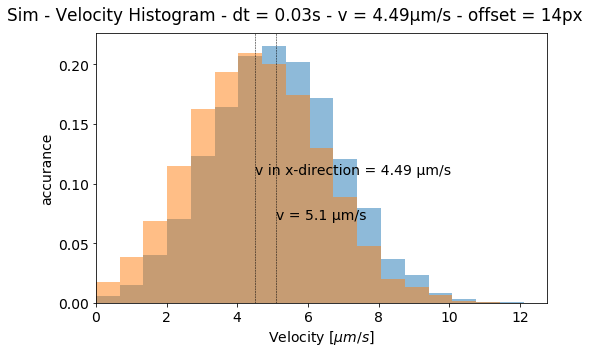

In [6]:
for i in range(1,shortlength):    #Calculate x-step, y-step, step length
    particlescamera[i,4] = particlescamera[i,0] - particlescamera[i-1,0]
    particlescamera[i,5] = particlescamera[i,1] - particlescamera[i-1,1]
    particlescamera[i,6] = np.sqrt(pow(particlescamera[i,4],2)+pow(particlescamera[i,5],2))
radialparticle = np.zeros((shortlength,2))
radialparticle[:,0] = particlescamera[:,6]
for i in range(shortlength):      #particle steps in polar coordinates
    if particlescamera[i,4] > 0: radialparticle[i,1] = np.arctan(particlescamera[i,5]/particlescamera[i,4])*180/np.pi
    else:
        if particlescamera[i,5] < 0: radialparticle[i,1] = (np.arctan(particlescamera[i,5]/particlescamera[i,4])-np.pi)*180/np.pi
        else: radialparticle[i,1] = (np.arctan(particlescamera[i,5]/particlescamera[i,4])+np.pi)*180/np.pi
corrangleright = np.mean(radialparticle[1:,1])               #correction angle for drift
radialparticle[:,1] -= corrangleright                        #substract the angle
particlescamera[:,9] = radialparticle[:,0]*np.cos(radialparticle[:,1]*np.pi/180)   #rewrite steps in cartesian coordinates
particlescamera[:,10] = radialparticle[:,0]*np.sin(radialparticle[:,1]*np.pi/180)
vright = np.mean(particlescamera[1:-1,6])*1e6/dt             #velocity
vrightx = np.mean(particlescamera[1:-1,9])*1e6/dt            #velocity in x-direction
meany = np.mean(particlescamera[1:,10])*1e6                  #mean y-position
varrightx = np.var(particlescamera[1:,9]*1e6)                #variance of the x-steps
varrighty = np.var(particlescamera[1:,10]*1e6)               #variance of the y-steps
varrightangle = np.var(radialparticle[1:-1,1])               #variance of the moving angle
HWHMrightangle = np.sqrt(2*np.log(2))*np.sqrt(varrightangle) #HWHM of the moving angle

binwave=np.linspace(0,max(particlescamera[1:-1,6]*1e6)/dt,20)
fig=plt.figure(1, figsize = (7.5,5) )                        #Plot histogram velocity
plt.subplot(1,1,1)
data = plt.hist(radialparticle[:,0]*1e6/dt,normed=1,bins=binwave,alpha=0.5,label='v')
data2 = plt.hist(particlescamera[1:,9]*1e6/dt,normed=1,bins=binwave,alpha=0.5,label='v in x-direction')
plt.axvline(x=vrightx,linewidth=0.5, color = 'k',linestyle='--')
plt.text(vrightx,max(data[0])/2,'v in x-direction = '+str(round(vrightx,2))+' µm/s')
plt.axvline(x=vright,linewidth=0.5, color = 'k',linestyle='--')
plt.text(vright,max(data2[0])/3,'v = '+str(round(vright,2))+' µm/s')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
plt.xlim([0,max(particlescamera[1:-1,6]*1e6)/dt])
plt.title(' ')
fig.suptitle('Sim - Velocity Histogram - dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout() 
plt.savefig('Sim - Velocity Histogram dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

In [7]:
#Check theory values
print('Theory - inserting: delay =',round(delaytime,2),'s - dt =',round(dt,2),'s - r =',round(radius*1e6,2),'µm - v =',round(vright,2),'µm/s - D =',round(D_0*1e12,2),'µm^2/s')
variance2 = 2*D_0*delaytime/radius**2
variance = 3*variance2
HWHM = np.sqrt(2*np.log(2))*np.sqrt(variance)*180/np.pi
sigma = 1/2 * (1-np.exp(-2*variance))
meanx = vright*np.exp(-variance/2)*dt
varx = (1-sigma)*vright**2*dt**2 - np.exp(-variance)*vright**2*dt**2 + 2*D_0*dt
vary = sigma*vright**2*dt**2 + 2*D_0*dt
varrightanglerad = varrightangle*np.pi/180
sigmaexp = 1/2 * (1-np.exp(-2*varrightanglerad))

print('sigma_theta^2     = ',round(variance,3),'rad (3 times theory value)')
print('HWHM_theta        = ',round(HWHM,3),'°')
print('sigma_{y,theta}^2 = ',round(sigma,3))
print(' ')
print('<x> - <x_0>       = ',round(meanx,2),'µm')
print('<y> - <y_0>       = ',0,'µm')
print('<x^2> - <x>^2     = ',round(varx,4),'µm^2')
print('<y^2> - <y>^2     = ',round(vary,4),'µm^2')
print('----------')
print('Experiment')
print('sigma_theta^2     = ',round(varrightanglerad,3),'rad')
print('HWHM_theta        = ',round(HWHMrightangle,3),'°')
print('sigma_{y,theta}^2 = ',round(sigmaexp,3))
print(' ')
print('<x> - <x_0>       = ',round(vrightx*dt,2),'µm')
print('<y> - <y_0>       = ',round(meany,3),'µm')
print('<x^2> - <x>^2     = ',round(varrightx,4),'µm^2')
print('<y^2> - <y>^2     = ',round(varrighty,4),'µm^2')

Theory - inserting: delay = 0.07 s - dt = 0.03 s - r = 1.1 µm - v = 5.1 µm/s - D = 0.07 µm^2/s
sigma_theta^2     =  0.027 rad (3 times theory value)
HWHM_theta        =  11.065 °
sigma_{y,theta}^2 =  0.026
 
<x> - <x_0>       =  0.15 µm
<y> - <y_0>       =  0 µm
<x^2> - <x>^2     =  0.0 µm^2
<y^2> - <y>^2     =  0.0006 µm^2
----------
Experiment
sigma_theta^2     =  17.242 rad
HWHM_theta        =  37.007 °
sigma_{y,theta}^2 =  0.5
 
<x> - <x_0>       =  0.13 µm
<y> - <y_0>       =  -0.001 µm
<x^2> - <x>^2     =  0.0032 µm^2
<y^2> - <y>^2     =  0.0049 µm^2


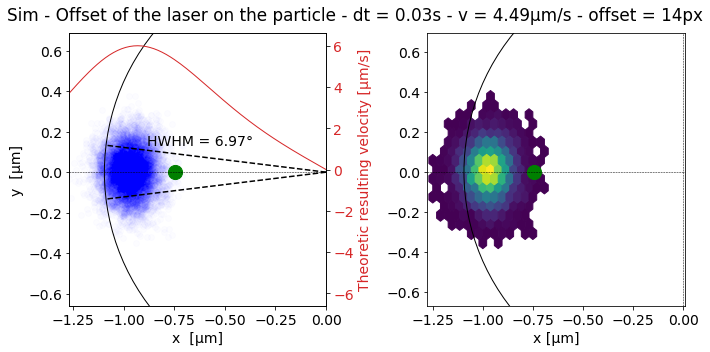

In [8]:
laseroffset = np.zeros((shortlength,3))   #Calculate the offset between the laser and the particle
for i in range(shortlength):              #at the timepoint where the laser is placed first
    laseroffset[i,0] = laser[i,0]-particlescamera[i,7]
    laseroffset[i,1] = laser[i,1]-particlescamera[i,8]
    laseroffset[i,2] = np.arctan((laser[i,1]-particlescamera[i,8])/(laser[i,0]-particlescamera[i,7]))*180/np.pi
varlaserx = np.var(laseroffset[1:,0]*1e6)                     #variance for x          
varlasery = np.var(laseroffset[1:,1]*1e6)                     #variance for y
varlaserangle = np.var(laseroffset[1:,2])                     #variance for the angle
HWHMlaserangle = np.sqrt(2*np.log(2))*np.sqrt(varlaserangle)  #HWHM for the angle
meanlaserx = np.mean(laseroffset[1:,0]*1e6)                   #mean for x
    
fig, ax = plt.subplots(figsize=(10, 5), sharey='all')         #Plot Laser offset
ax = plt.subplot(1,2,1)
plt.scatter((laser[1:-1,0]-particlescamera[1:-1,7])*1e6,(laser[1:-1,1]-particlescamera[1:-1,8])*1e6,c='b',alpha = 0.01)
plt.xlabel('x  [µm]')
plt.ylabel('y  [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
x = np.cos(HWHMlaserangle*np.pi/180)*radius*1e6
y = np.sin(HWHMlaserangle*np.pi/180)*radius*1e6
plt.plot([0,-x],[0,y],'k--')
plt.plot([0,-x],[0,-y],'k--')
plt.text(-x+0.2,y,'HWHM = '+str(round(HWHMlaserangle,2))+'°')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), radius*1e6 , color='k', fill=False)
ax.add_artist(circle2)
plt.scatter(-offset*pxtomum*1e6,0,color='g',s=200)
xmin = min(offset*pxtomum*1e6,min((laser[1:-1,0]-particlescamera[1:-1,7])*1e6),-1.1*radius*1e6)
xmax = max(max((laser[1:-1,0]-particlescamera[1:-1,7])*1e6),0)
ax.axis('equal')
ax.set_xlim([xmin,xmax])
plt.title(' ')

ax1 = ax.twinx()
color = 'tab:red'
ax1.plot(-velparticle[:,0]*1e6,velparticle[:,1]*1e6, color=color, linewidth = 1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1.1*max(velparticle[:,1]*1e6),1.1*max(velparticle[:,1]*1e6))
ax1.set_ylabel('Theoretic resulting velocity [µm/s]',color=color)

gridsizevalue = 15
ax2 = plt.subplot(1,2,2)
hb = ax2.hexbin((laser[1:-1,0]-particlescamera[1:-1,7])*1e6,(laser[1:-1,1]-particlescamera[1:-1,8])*1e6, gridsize=gridsizevalue,mincnt=0.01)
plt.xlabel('x [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), radius*1e6 , color='k', fill=False)
ax2.axis('equal')
ax2.add_artist(circle2)
plt.scatter(-offset*pxtomum*1e6,0,color='g',s=200)
ax2.set_xlim([xmin,xmax])

ax.set_xlim([xmin,xmax])
plt.title(' ')
fig.suptitle('Sim - Offset of the laser on the particle - dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')

plt.tight_layout()  
plt.savefig('Sim - Laser offset dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

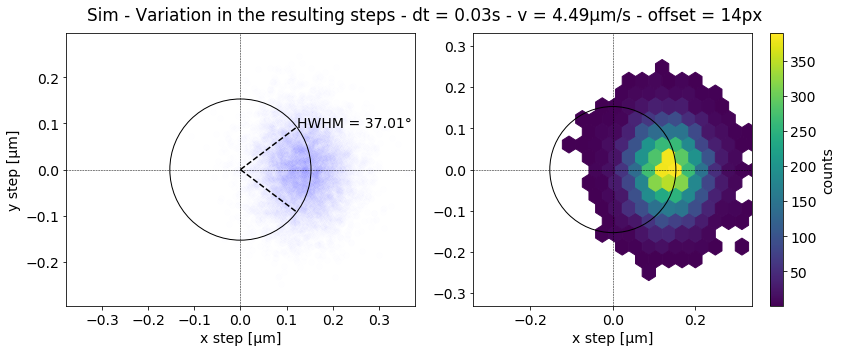

In [9]:
fig, ax = plt.subplots(figsize=(12, 5), sharey='all')
ax = plt.subplot(1,2,1)
plt.scatter(particlescamera[5:-1,9]*1e6,particlescamera[5:-1,10]*1e6,c='b',alpha = 0.002)
plt.xlabel('x step [µm]')
plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(particlescamera[1:,6]*1e6) , color='k', fill=False)
ax.add_artist(circle2)
limit = np.nanmax(abs(particlescamera[1:,9:10]))*1e6
ax.axis('equal')
ax.set_xlim([-limit,limit])
ax.set_ylim([-limit,limit])
plt.title(' ')
x = np.cos(HWHMrightangle*np.pi/180)*np.nanmean(particlescamera[1:,6]*1e6)
y = np.sin(HWHMrightangle*np.pi/180)*np.nanmean(particlescamera[1:,6]*1e6)
plt.plot([0,x],[0,y],'k--')
plt.plot([0,x],[0,-y],'k--')
plt.text(x,y,'HWHM = '+str(round(HWHMrightangle,2))+'°')

gridsizevalue = 15
ax2 = plt.subplot(1,2,2)
hb = ax2.hexbin(particlescamera[5:-1,9]*1e6,particlescamera[5:-1,10]*1e6, gridsize=gridsizevalue,mincnt=0.01)
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('counts')
plt.xlabel('x step [µm]')
#plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(particlescamera[1:,6])*1e6 , color='k', fill=False)
ax2.add_artist(circle2)
ax2.axis('equal')
ax2.set_xlim([-limit,limit])
ax2.set_ylim([-limit,limit])
plt.title(' ')

fig.suptitle('Sim - Variation in the resulting steps - dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Sim - Resulting steps dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

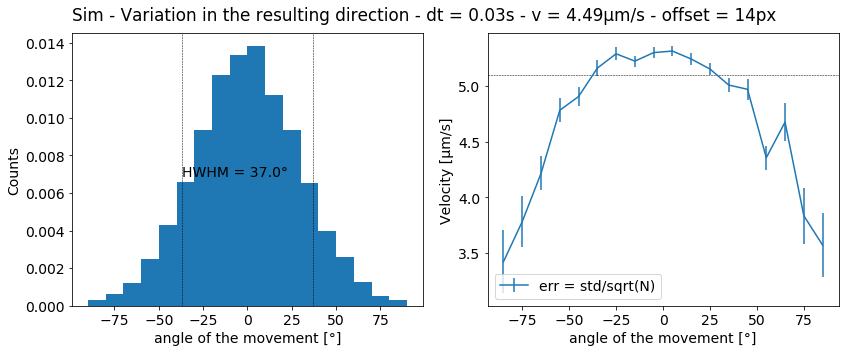

In [10]:
anglewave = np.linspace(-90,90,19)
collectv = np.zeros((shortlength,19))
count = np.zeros(19)
for i in range(2,shortlength-1):
    j = 1; check = False
    while check == False:
        if radialparticle[i,1] < anglewave[j] and radialparticle[i,1] > anglewave[j-1]:
            collectv[int(count[j]),j] = radialparticle[i,0]#/dt#particlescamera[i,9]#
            count[j] += 1
            check = True
        else: j += 1
        if j == 19:
            check = True
            
averagev = np.zeros((19,2))
for i in range(1,19):
    averagev[i,0] = np.mean(collectv[:int(count[i]),i])
    averagev[i,1] = np.std(collectv[:int(count[i]),i])
averagev[:,1] /= np.sqrt(count[:])
    
anglewave2 = np.zeros(18)
for i in range(18):
    anglewave2[i] = (anglewave[i]+anglewave[i+1])/2
    
fig, ax = plt.subplots(figsize=(12, 5), sharey='all')
ax = plt.subplot(1,2,1)
binwave = np.linspace(-90,90,19)
data = plt.hist(radialparticle[1:,1],bins=binwave,normed=1)
plt.axvline(x=HWHMrightangle,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=-HWHMrightangle,linewidth=0.5, color = 'k',linestyle='--')
plt.text(-HWHMrightangle,max(data[0])/2,'HWHM = '+str(round(HWHMrightangle,1))+'°')
plt.xlabel('angle of the movement [°]')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
plt.errorbar(anglewave2,averagev[1:,0]*1e6/dt,yerr= averagev[1:,1]*1e6/dt,label='err = std/sqrt(N)')
plt.axhline(y=np.mean(particlescamera[1:,6]*1e6/dt),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('angle of the movement [°]')
plt.ylabel('Velocity [µm/s]')
plt.title(' ')
plt.legend()

fig.suptitle('Sim - Variation in the resulting direction - dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Sim - Velocity vs Direction dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

np.savetxt('DataSim-v'+str(round(vrightx,2))+'.txt', np.transpose([vright,vrightx,corrangleright,HWHMrightangle,varrightx,varrighty,HWHMlaserangle,varlaserx,varlasery,meanlaserx,-pxtomum*offset*1e6]),fmt='%1.6f')